In [1]:
from feature_engine import FeatureEngine
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score
import shap

/Users/nikhilnarayanan/Desktop/FYP/REPLACE-BG/my-python3-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = FeatureEngine()

In [3]:
dataset.training_set.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,id,06:00:00,06:05:00,06:10:00,06:15:00,06:20:00,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Year_2014,Year_2015,Year_2016
0,0,0,0,0,2,163.0,159.0,155.0,152.0,147.0,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1,1,2,214.0,215.0,221.0,231.0,241.0,...,0,0,0,0,0,0,0,0,1,0
2,2,2,2,2,2,115.0,114.0,116.0,118.0,121.0,...,0,0,0,0,0,0,0,0,1,0
3,3,3,3,3,2,206.0,207.0,207.0,209.0,211.0,...,0,0,0,0,0,0,0,0,1,0
4,4,4,4,4,2,169.0,171.0,173.0,173.0,174.0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
training_X = dataset.training_set.iloc[:,222:]
validation_X = dataset.validation_set.iloc[:,220:]
training_Y = dataset.training_set.iloc[:, 221]
validation_Y = dataset.validation_set.iloc[:, 219]

In [5]:
rus = RandomUnderSampler()
x_train, y_train = rus.fit_resample(training_X, training_Y)

In [6]:
validation_X['Year_2014'] = 0
#validation_X.drop(columns=['Year_2013'], inplace=True)
cols = np.array(training_X.columns)
validation_X = validation_X[cols]

In [7]:
bst = XGBClassifier(objective="binary:logistic", eval_metric="auc")
bst.fit(training_X, training_Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
preds = bst.predict(training_X)
roc_auc_score(training_Y, preds)

0.5921066616831626

In [11]:
preds = bst.predict(validation_X)

def safe_convert_to_float(array):
    try:
        return array.astype(float)
    except ValueError:
        # If conversion fails, attempt to coerce manually, substituting NaNs for unconvertible entries
        converted = np.array([float(x) if isinstance(x, (int, float)) else np.nan for x in array])
        return converted

# Convert both arrays, handling non-convertible types
validation_Y = safe_convert_to_float(validation_Y)
preds = safe_convert_to_float(preds)

# Find indices where either array has a NaN
nan_indices = np.where(np.isnan(validation_Y) | np.isnan(preds))[0]

# Remove the indices with NaNs from both arrays
validation_Y_clean = np.delete(validation_Y, nan_indices)
preds_clean = np.delete(preds, nan_indices)

# Now you can compute roc_auc_score without encountering NaN issues
roc_auc_score(validation_Y_clean, preds_clean)


0.503056357510604

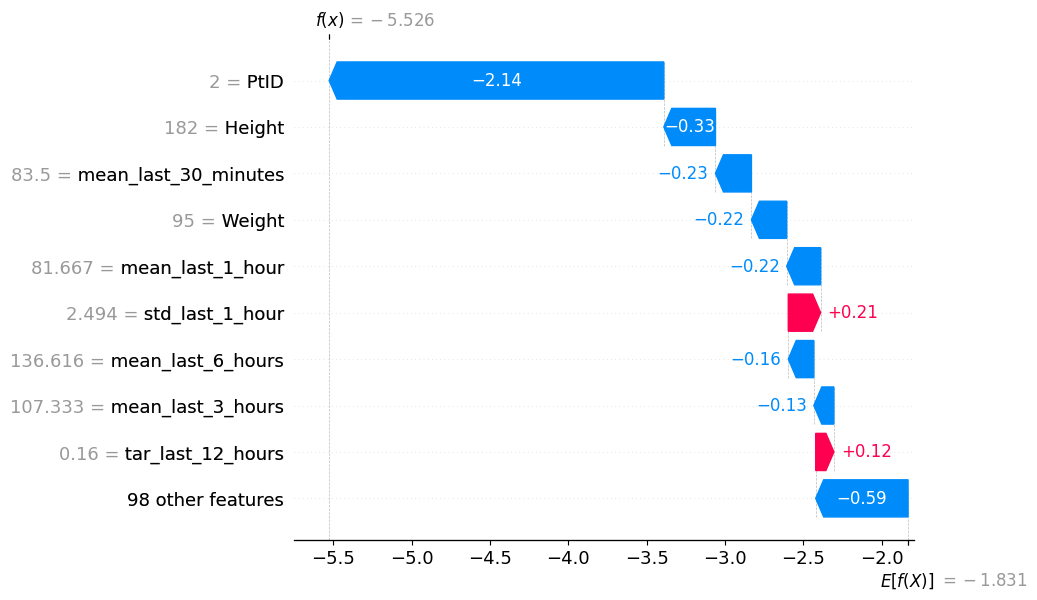

In [12]:
explainer = shap.Explainer(bst)
shap_values = explainer(training_X)
shap.plots.waterfall(shap_values[0])